# Scikits ODE solver

In this notebook, we show some examples of solving an ODE model using the Scikits ODE solver, which interfaces with the [SUNDIALS](https://computation.llnl.gov/projects/sundials) library via the [scikits-odes](https://scikits-odes.readthedocs.io/en/latest/) Python interface

In [1]:
# Setup
%matplotlib inline
import pybamm
import tests
import numpy as np
import os
import matplotlib.pyplot as plt
from pprint import pprint
os.chdir(pybamm.__path__[0]+'/..')

# Create solver
ode_solver = pybamm.ScikitsOdeSolver()

## Integrating ODEs

In the simplest case, the `integrate` method of the ODE solver needs to be passed a function that returns `dydt` at `(t,y)`, initial conditions `y0`, and a time `t_eval` at which to return the solution:

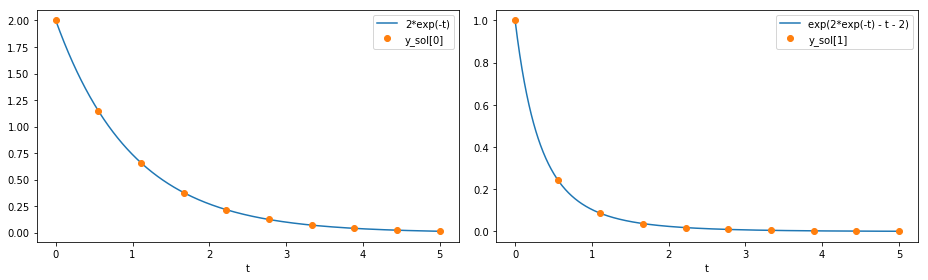

In [2]:
def exponential_decay(t, y):
    return np.array([-y[0], - (1.0 + y[0]) * y[1]])

# Solve
y0 = np.array([2., 1.])
t_eval = np.linspace(0, 5, 10)
t_sol, y_sol = ode_solver.integrate(exponential_decay, y0, t_eval)

# Plot
def plot(t_sol, y_sol):
    t_fine = np.linspace(0,t_eval[-1],1000)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
    ax1.plot(t_fine, 2 * np.exp(-t_fine), t_sol, y_sol[0], "o")
    ax1.set_xlabel("t")
    ax1.legend(["2*exp(-t)", "y_sol[0]"], loc="best")

    ax2.plot(t_fine, np.exp(2 * np.exp(-t_fine) - t_fine - 2), t_sol, y_sol[1], "o")
    ax2.set_xlabel("t")
    ax2.legend(["exp(2*exp(-t) - t - 2)", "y_sol[1]"], loc="best")

    plt.tight_layout()
    plt.show()
    
plot(t_sol, y_sol)

We can also provide the Jacobian

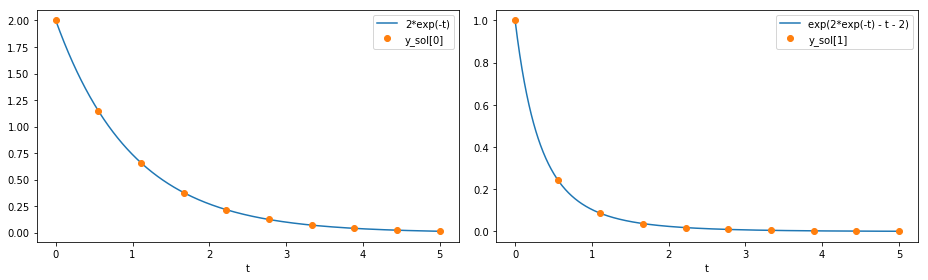

In [3]:
def jacobian(t, y):
    return np.array([[-1.0, 0.0], [-y[1], -(1 - y[0])]])

t_sol, y_sol = ode_solver.integrate(exponential_decay, y0, t_eval, jacobian=jacobian)

plot(t_sol, y_sol)

It is also possible to provide a mass matrix to the `integrate` method by using the key-word argument `mass_matrix`, but this is currently not used by the Scikits ODE solver. 

Finally, we can specify events at which the solver should terminate

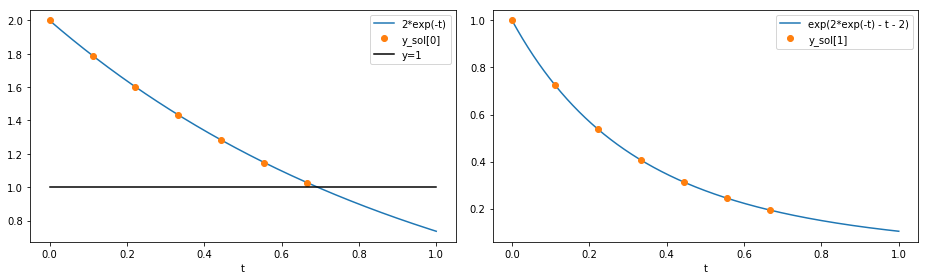

In [4]:
def y0_equal_1(t, y):
    return y[0] - 1

# Solve
t_eval = np.linspace(0, 1, 10)
t_sol, y_sol = ode_solver.integrate(exponential_decay, y0, t_eval, events=[y0_equal_1])

# Plot
t_fine = np.linspace(0,t_eval[-1],1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_fine, 2 * np.exp(-t_fine), t_sol, y_sol[0], "o", t_fine, np.ones_like(t_fine), "k")
ax1.set_xlabel("t")
ax1.legend(["2*exp(-t)", "y_sol[0]", "y=1"], loc="best")

ax2.plot(t_fine, np.exp(2 * np.exp(-t_fine) - t_fine - 2), t_sol, y_sol[1], "o")
ax2.set_xlabel("t")
ax2.legend(["exp(2*exp(-t) - t - 2)", "y_sol[1]"], loc="best")

plt.tight_layout()
plt.show()

## Solving a model

The `solve` method is common to all ODE solvers. It takes a model, which contains all of the above information (derivatives function, initial conditions and optionally jacobian, mass matrix, events), and a time to evaluate `t_eval`, and calls `integrate` to solve this model. 

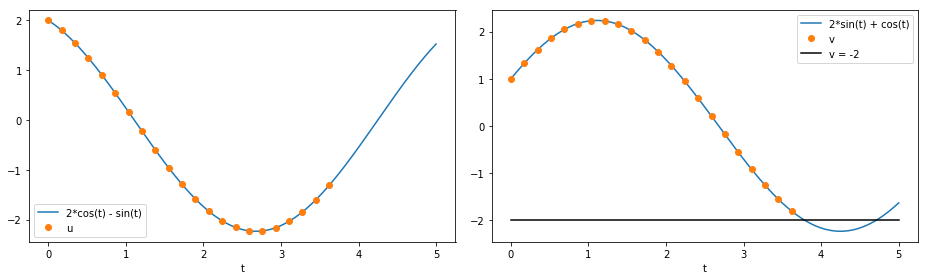

In [5]:
# Create model
model = pybamm.BaseModel()
u = pybamm.Variable("u")
v = pybamm.Variable("v")
model.rhs = {u: -v, v: u}
model.initial_conditions = {u: 2, v: 1}
model.events = [v + 2]
model.variables = {"u": u, "v": v}

# Discretise using default discretisation
disc = tests.StandardModelTest(model).disc
disc.process_model(model)

# Solve ########################
t_eval = np.linspace(0, 5, 30)
ode_solver.solve(model, t_eval)
################################

# Post-process, so that u and v can be called at any time t (using interpolation)
t_sol, y_sol = ode_solver.t, ode_solver.y
u = pybamm.ProcessedVariable(model.variables["u"], t_sol, y_sol)
v = pybamm.ProcessedVariable(model.variables["v"], t_sol, y_sol)

# Plot
t_fine = np.linspace(0,t_eval[-1],1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_fine, 2 * np.cos(t_fine) - np.sin(t_fine), t_sol, u(t_sol), "o")
ax1.set_xlabel("t")
ax1.legend(["2*cos(t) - sin(t)", "u"], loc="best")

ax2.plot(t_fine, 2 * np.sin(t_fine) + np.cos(t_fine), t_sol, v(t_sol), "o", t_fine, -2 * np.ones_like(t_fine), "k")
ax2.set_xlabel("t")
ax2.legend(["2*sin(t) + cos(t)", "v", "v = -2"], loc="best")

plt.tight_layout()
plt.show()

Note that the discretisation or solver will have created the mass matrix and jacobian algorithmically, using the expression tree, so we do not need to calculate and input these manually.